# Learning Weights for the Draco Model

In this example, we are using a linear SVM model to learn weights for a Draco model. The input to the model are pairs of visualizations where one visualization is preferred to another. We then try to find weights such that most of the pairs are correctly classified. Each visualization is represented as a vector of number of violations.

Given pairs of preferred (positive) $\lbrack u_1, u_2, ..., u_k \rbrack$ and a not preferred (negative) $\lbrack v_1, v_2, ..., v_k \rbrack$ visualization, we try to maximize the distance between these vectors using ${\arg\max}_w \sum_{i\, \in\, 0...k} w_i \, (u_i-v_i)$. To implement this loss, we subtract the positive and negative vectors and learn weights using a linear SVM with one class.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from draco.data_utils import pairs_to_vec
from draco.learn import train_model
from sklearn.decomposition import PCA

from draco import Draco

In [2]:
default_draco = Draco()

In [3]:
def train_and_plot(data: pd.DataFrame, test_size: float = 0.3):
    """use SVM to classify them and then plot them after projecting X, y into 2D using PCA"""
    X = data.negative - data.positive

    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    clf = train_model(X, test_size)

    # for plotting
    X0, X1 = X2[:, 0], X2[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    f, ax = plt.subplots(figsize=(8, 6))

    # predictions made by the model
    pred = clf.predict(X)

    correct = pred > 0

    plt.scatter(
        X0[correct],
        X1[correct],
        c=["green"],
        alpha=0.5,
        marker=">",
        label="correct",
    )
    plt.scatter(
        X0[~correct],
        X1[~correct],
        c=["red"],
        alpha=0.5,
        marker="<",
        label="incorrect",
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_xlabel("X0")
    ax.set_ylabel("X1")

    ax.set_xticks(())
    ax.set_yticks(())

    plt.title("Predictions of Linear Model")

    plt.annotate(
        f"Score: {clf.score(X, np.ones(len(X))):.{5}}. N: {int(len(data))}",
        (0, 0),
        (0, -20),
        xycoords="axes fraction",
        textcoords="offset points",
        va="top",
    )

    plt.legend(loc="lower right")
    plt.axis("tight")

    plt.show()

    return clf


def project_and_plot(data: pd.DataFrame, test_size: float = 0.3):
    """Reduce X, y into 2D using PCA and use SVM to classify them
    Then plot the decision boundary as well as raw data points
    """
    X = data.negative - data.positive

    pca = PCA(n_components=2)
    X = pca.fit_transform(X)

    clf = train_model(X, test_size)

    # for plotting
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    f, ax = plt.subplots(figsize=(8, 6))

    plot_contours(ax, clf, xx, yy)

    # predictions made by the model
    pred = clf.predict(X)

    correct = pred > 0

    plt.scatter(
        X0[correct],
        X1[correct],
        c=["g"],
        alpha=0.5,
        marker=">",
        label="correct",
    )
    plt.scatter(
        X0[~correct],
        X1[~correct],
        c=["r"],
        alpha=0.5,
        marker="<",
        label="incorrect",
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_xlabel("X0")
    ax.set_ylabel("X1")

    ax.set_xticks(())
    ax.set_yticks(())

    plt.title("Predictions of Linear Model")

    plt.annotate(
        f"Score: {clf.score(X, np.ones(len(X))):.{5}}. N: {int(len(data))}",
        (0, 0),
        (0, -20),
        xycoords="axes fraction",
        textcoords="offset points",
        va="top",
    )

    plt.legend(loc="lower right")
    plt.axis("tight")

    plt.show()

    return clf


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Params:
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def make_meshgrid(x, y, h=0.01):
    """Create a mesh of points to plot in
    Params:
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional
    Returns:
        xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [4]:
learn_data = {}

with open("./data/saket2018_draco2.json") as file:
    i = 0
    json_data = json.load(file)

    for pair in json_data:
        pair["source"] = "saket_2018"
        pair["pair_id"] = f"{pair['source']}_{i}"
        learn_data[pair["pair_id"]] = pair
        i += 1

data = pairs_to_vec(learn_data)

assert set(data.negative.columns) == set(default_draco.soft_constraint_names), (
    "Feature names do not match."
)

INFO:draco.data_utils:Running 1 partitions of 10 items in parallel on {processes} processes.
INFO:draco.data_utils:Hash of dataframe: 10097616555658106052


/Users/petergy/Library/Caches/pypoetry/virtualenvs/draco-WeZzPe1I-py3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train score:  0.5714285714285714
Dev score:  0.3333333333333333


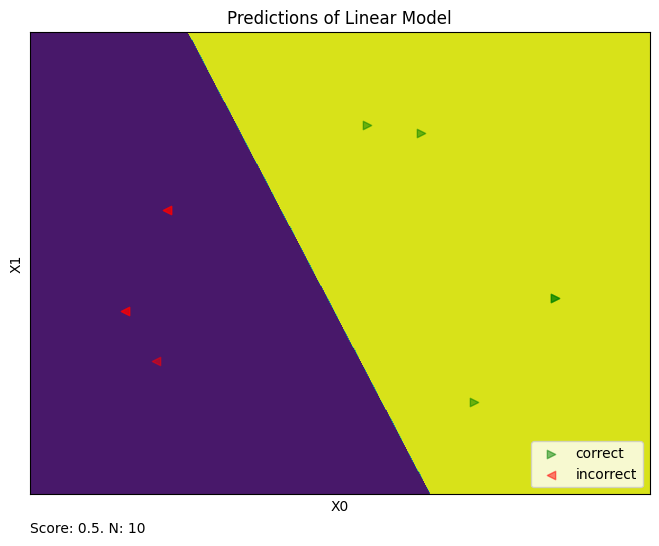

LinearSVC(C=1, fit_intercept=False)

In [5]:
project_and_plot(data, test_size=0.3)

Train score:  1.0
Dev score:  1.0


/Users/petergy/Library/Caches/pypoetry/virtualenvs/draco-WeZzPe1I-py3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


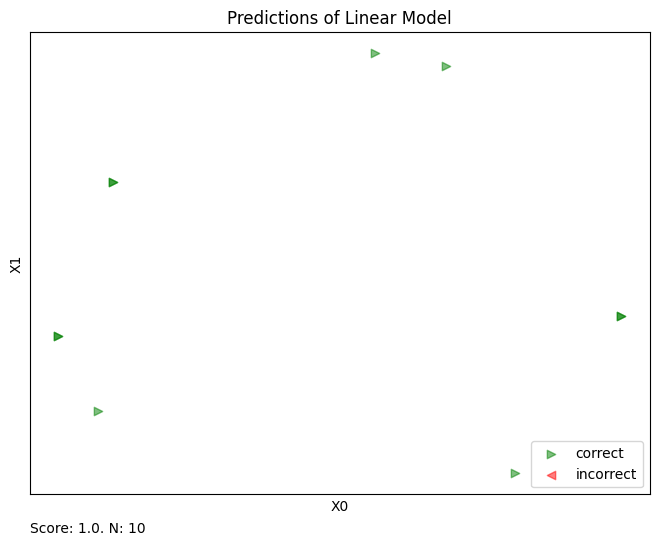

In [6]:
clf = train_and_plot(data, test_size=0.3)

In [7]:
features = data.negative.columns
new_weights = {}

for feature, weight in zip(features, clf.coef_[0]):
    print(f"#const {feature}_weight = {int(weight * 1000)}.")
    new_weights[f"{feature}_weight"] = int(weight * 1000)

#const aggregate_weight = 0.
#const aggregate_count_weight = 0.
#const aggregate_group_by_raw_weight = 131.
#const aggregate_max_weight = 0.
#const aggregate_mean_weight = 0.
#const aggregate_median_weight = 0.
#const aggregate_min_weight = 0.
#const aggregate_no_discrete_weight = 131.
#const aggregate_stdev_weight = 0.
#const aggregate_sum_weight = 0.
#const bin_weight = 0.
#const bin_high_weight = 0.
#const bin_low_weight = 0.
#const bin_low_unique_weight = 0.
#const bin_not_linear_weight = 0.
#const binned_orientation_not_x_weight = 0.
#const c_c_area_weight = 0.
#const c_c_line_weight = 371.
#const c_c_point_weight = -240.
#const c_c_text_weight = 0.
#const c_d_col_weight = 0.
#const c_d_no_overlap_area_weight = 0.
#const c_d_no_overlap_bar_weight = -258.
#const c_d_no_overlap_line_weight = -404.
#const c_d_no_overlap_point_weight = 531.
#const c_d_no_overlap_text_weight = 0.
#const c_d_no_overlap_tick_weight = 0.
#const c_d_overlap_area_weight = 0.
#const c_d_overlap_bar_weight = 

## How to use the learned weights?

For how to do recomendation with default weights, refer to [Visualization Recomendation](https://dig.cmu.edu/draco2/applications/recommendation.html). 

In this example, we use the learned weights above to recommand visualizations.

First, we pass the new learned weights to Draco as following:


In [8]:
from pprint import pprint

from draco import answer_set_to_dict

new_draco = Draco(weights=new_weights)

Then, we can continue with the same procedure as in default [Visualization Recommendation](https://dig.cmu.edu/draco2/applications/recommendation.html). 
And as you can see, the recommended result from the same input based on the learned weights is different from the one in default. 

Note that whether it generates better recommendations or not depends on the examples you learned from. 

In [9]:
import importlib.resources as pkg_resources

import draco.asp.examples as examples

hist_spec = pkg_resources.read_text(examples, "histogram.lp")

print("INPUT:")
print(hist_spec)

print("OUTPUT:")
model = next(new_draco.complete_spec(hist_spec))
pprint(answer_set_to_dict(model.answer_set))

print("VIOLATED PREFERENCES:")
pprint(new_draco.count_preferences(str(model)))

INPUT:
attribute(number_rows,root,100).

entity(field,root,(f,0)).
attribute((field,name),(f,0),temp_max).
attribute((field,type),(f,0),number).
attribute((field,unique),(f,0),100).

entity(view,root,(v,0)).

entity(mark,(v,0),(m,0)).
entity(encoding,(m,0),(e,0)).
attribute((encoding,field),(e,0),temp_max).
attribute((encoding,binning),(e,0),10).

#show entity/3.
#show attribute/3.

OUTPUT:
{'field': [{'name': 'temp_max', 'type': 'number', 'unique': 100}],
 'number_rows': 100,
 'task': 'value',
 'view': [{'coordinates': 'polar',
           'mark': [{'encoding': [{'binning': 10,
                                   'channel': 'detail',
                                   'field': 'temp_max'},
                                  {'aggregate': 'max',
                                   'channel': 'color',
                                   'field': 'temp_max'},
                                  {'aggregate': 'max',
                                   'channel': 'x',
                             